In [1]:
pip install num2words

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install inflect

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install spacy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Integrantes**
- Joan Sebastian Amaya Bohórquez
- Nicolás Lara Goméz
- David Mateo Barbosa Monsalve


In [6]:
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Versiones anteriores a 1.2 de sklearn: from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer 
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 
from sklearn import tree
import sklearn as sklearn
#importar libreria de lenguaje natural
import nltk
from num2words import num2words
import contractions
import inflect

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import unicodedata
import spacy
from wordcloud import WordCloud

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soyyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soyyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soyyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\soyyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


# **Sección 2. Entendimiento y preparación de los datos**

En primer lugar se cargan los datos y se observan sus características principales para un entendimiento básico de los datos y un posterior análisis.

In [9]:
data=pd.read_csv('fake_news_spanish.csv', sep=';', encoding = 'utf-8')
data.info()
data.shape
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [10]:
data.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


Se cuenta la cantidad de elementos por cada valor del atributo "Label"

In [11]:
counts = data['Label'].value_counts()
print(f"Cantidad de 1s: {counts.get(1, 0)}")
print(f"Cantidad de 0s: {counts.get(0, 0)}")

Cantidad de 1s: 33158
Cantidad de 0s: 23905


A continuación se realizara una nube de palabras con el fin de observar de forma cualitativa algunas de las más usadas dentro de todo el dataset

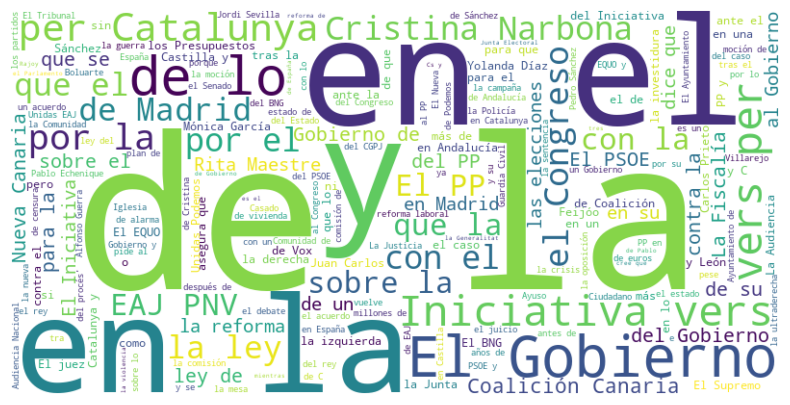

In [12]:

text = " ".join(data["Titulo"].dropna()) 
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Gráfica nube de palabras

La nube de palabras muestra los términos más frecuentes en el dataset de noticias, con un énfasis en palabras como **"de", "en", "la", "el", "Gobierno"** y **"Congreso"**, lo que sugiere una temática centrada en asuntos políticos. El tamaño de cada palabra indica su frecuencia relativa dentro del texto, permitiendo identificar patrones en el lenguaje utilizado. Además, se observan nombres de entidades y referencias geográficas, lo que refuerza la idea de que las noticias analizadas están relacionadas con eventos gubernamentales y políticos.


Text(0.5, 1.0, 'Histograma de frecuencias')

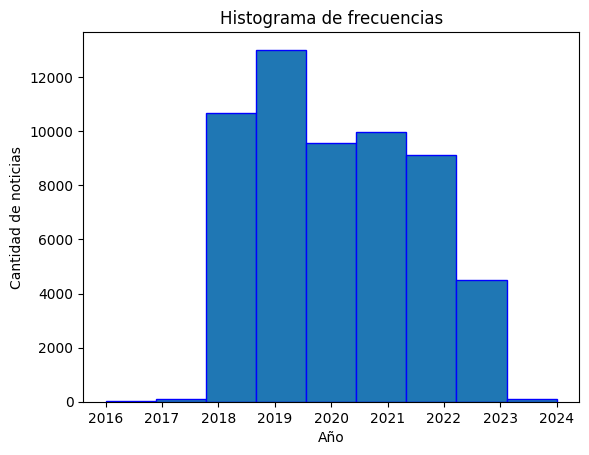

In [13]:
#Crear frecuencia de las fechas
frecuencia=[]
cantidadBins=set()
for fecha in data["Fecha"]:
    if fecha:
        year=fecha.split("/")[2]
        frecuencia.append(int(year))
        cantidadBins.add(year)
plt.hist(frecuencia,bins=len(cantidadBins),edgecolor="Blue")
plt.xlabel("Año")
plt.ylabel("Cantidad de noticias")
plt.title("Histograma de frecuencias")
        


El histograma muestra la distribución de la cantidad de noticias a lo largo de los años. Se observa un aumento significativo en la frecuencia de noticias entre 2018 y 2020, alcanzando su punto máximo en 2019. Posteriormente, hay una ligera disminución en 2021 y 2022, seguida de una caída más pronunciada en 2023. La cantidad de noticias en 2024 es mínima, lo que puede deberse a que el año está en curso o a una menor cantidad de datos disponibles para ese periodo.

Otra posible métrica para entender las noticias es analizar su extensión en palabras. Un posible enfoque que nos puede ayudar para abordar este problema es comparar la longitud de las noticias falsas con la de aquellas que no lo son.

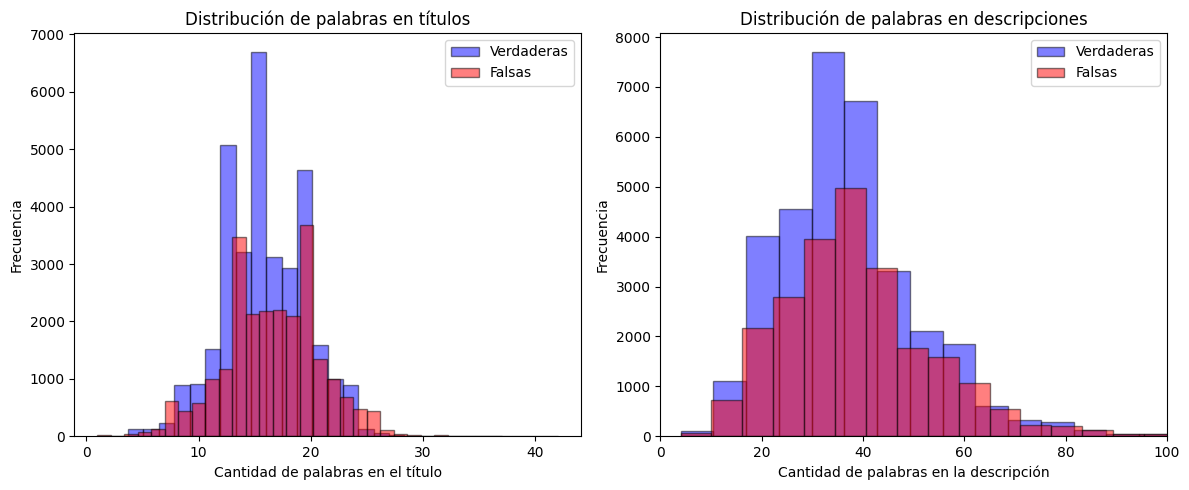

In [14]:
def longitudTexto(texto):
    texto=str(texto)
    if texto:
        longitud=len(texto.split(" "))
    else:
        longitud=0
    return longitud

def longitudDescripcion(texto):
    texto=str(texto)
    if texto:
        longitud=len(texto.split(" "))
    else:
        longitud=0
    return longitud

data["CantidadPalabrasTitulo"]=data["Titulo"].apply(longitudTexto)
data["CantidadPalabrasDescripcion"]=data["Descripcion"].apply(longitudDescripcion)

verdaderas = data[data["Label"] == 1 ]
falsas = data[data["Label"] == 0]

verdaderasDescripcion = data[(data["Label"] == 1) & (data["CantidadPalabrasDescripcion"] < 200)]
falsasDescripcion = data[(data["Label"] == 0) & (data["CantidadPalabrasDescripcion"] < 200)]



fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(verdaderas["CantidadPalabrasTitulo"], bins=30, alpha=0.5, label="Verdaderas", color="blue", edgecolor="black")
axes[0].hist(falsas["CantidadPalabrasTitulo"], bins=30, alpha=0.5, label="Falsas", color="red", edgecolor="black")
axes[0].set_xlabel("Cantidad de palabras en el título")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de palabras en títulos")
axes[0].legend()

axes[1].set_xlim(0, 100)
axes[1].hist(verdaderasDescripcion["CantidadPalabrasDescripcion"], bins=30, alpha=0.5, label="Verdaderas", color="blue", edgecolor="black")
axes[1].hist(falsasDescripcion["CantidadPalabrasDescripcion"], bins=30, alpha=0.5, label="Falsas", color="red", edgecolor="black")
axes[1].set_xlabel("Cantidad de palabras en la descripción")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de palabras en descripciones")
axes[1].legend()

plt.tight_layout()
plt.show()


El gráfico muestra la distribución de la cantidad de palabras en los títulos y descripciones de noticias verdaderas y falsas. Se observa que ambas distribuciones son bastante similares, lo que sugiere que la cantidad de palabras no es un factor determinante para diferenciar entre noticias verdaderas y falsas.

Dado que esta métrica no aporta información clara para la clasificación, el análisis se enfocará únicamente en el contenido del texto en lugar de su extensión.

Además, se ha aplicado un filtro para limitar la longitud del texto hasta 200 palabras. Esto evita que valores extremos reduzcan la resolución del histograma y permite una mejor visualización de las tendencias principales.

In [15]:
data.drop(columns=["CantidadPalabrasTitulo"], inplace=True)
data.drop(columns=["CantidadPalabrasDescripcion"], inplace=True)

## **2.1 Completitud**
Se buscan los registros con valores faltantes y se decide, desde el contexto del negocio, qué se puede hacer con ellos.

In [16]:
data.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Como se puede apreciar, entre los más de 50000 registros, solo hay 16 en los que el campo de Título toma valor nulo. Como la proporción entre estos valores nulos y la cantidad de datos es sumamente reducida, se tomó la decisión de eliminar estos registros. Inicialmente se consideró emplear diferentes métricas para reemplazar estos valores, pero como las variables son textos de noticias, emplear métodos como el reemplazo por la moda serían muy poco útiles.

In [17]:
#Eliminar los registros nulos
data_sin_nulos = data.dropna()
data_sin_nulos.shape

(57047, 5)

## **2.2 Unicidad**  

Para garantizar que el modelo no asigne un peso indebido a ciertos valores debido a su repetición, se buscarán y eliminarán los duplicados en los datos.  

En primer lugar, se identificarán los **duplicados totales**, es decir, aquellos registros donde todas las columnas sean exactamente iguales. La eliminación de estos valores redundantes contribuirá a mejorar la generalización del modelo y evitará sesgos no deseados.  

 

In [18]:
#a = data_sin_nulos.duplicated().sum()
data_full = data_sin_nulos.drop_duplicates()
data_full.shape

(56602, 5)

Ahora se buscarán duplicados parciales, es decir, filas donde algunas columnas estén repetidas. Se tratará de identificar aquellas que sean redundantes sin considerar el ID y el Label. Dado que los datos más importantes son el título y la descripción, al representar el contenido de la noticia, también se buscarán registros en los que estas columnas sean idénticas

In [19]:
duplicados = data_full.duplicated(subset=data_full.columns.difference(['Label','id'])).sum()
print(f"Cantidad de duplicados parciales: {duplicados}")
data_full=data_full.drop_duplicates(subset=data_full.columns.difference(['Label','id']))
data_full.shape

Cantidad de duplicados parciales: 1


(56601, 5)

In [20]:
duplicados = data_full.duplicated(subset=data_full.columns.difference(['Label','id','Fecha'])).sum()
print(f"Cantidad de duplicados parciales: {duplicados}")
data_full=data_full.drop_duplicates(subset=data_full.columns.difference(['Label','id','Fecha']))
data_full.shape

Cantidad de duplicados parciales: 4


(56597, 5)

Se decidió eliminar los duplicados parciales, ya que su cantidad es mínima (solo 5 en un conjunto de datos de más de 50,000). Por lo tanto, su eliminación no afectará ni introducirá sesgos en el modelo a futuro.


## **2.3 Consistencia**

El dataset presenta una estructura uniforme, con columnas bien definidas y tipos de datos adecuados para su propósito. La cantidad de registros se mantiene estable en la mayoría de las columnas, asegurando coherencia en la información. Además, el uso eficiente de la memoria indica que los datos están correctamente almacenados y organizados. Estas características garantizan que el conjunto de datos es consistente y apto para su uso en el modelo sin problemas estructurales.  


## **2.4 Validez**

Dentro de los campos del DataFrame, se analiza la validez sobre la única columna que está basada en un formato específico. Esta es la columna de Fecha. La validez se cumple asegurando que todas las fechas sigan el formato correcto, identificando y separando aquellas que no cumplen con el estándar esperado.

In [21]:
def verificar_formato_fecha(df, columna):
    """Verifica si todas las fechas de la columna siguen el formato DD/MM/YYYY.

    :param df: DataFrame de pandas.
    :param columna: Nombre de la columna a verificar.
    :return: DataFrame con filas que tienen fechas en un formato incorrecto.
    """
    formato = "%d/%m/%Y"
    
    # Intentar convertir la columna a datetime con el formato esperado
    try:
        fechas_validas = pd.to_datetime(df[columna], format=formato, errors='coerce')
    except Exception as e:
        print(f"Error al procesar fechas: {e}")
        return None
    
    # Filtrar filas con valores no convertidos (NaT significa formato incorrecto)
    fechas_invalidas = df[fechas_validas.isna()]
    
    if fechas_invalidas.empty:
        print("Todas las fechas tienen el formato correcto (DD/MM/YYYY).")
    else:
        print("Se encontraron fechas con formato incorrecto:")
        print(fechas_invalidas)
    
    return fechas_invalidas


fechas_invalidas = verificar_formato_fecha(data_full, 'Fecha')

Todas las fechas tienen el formato correcto (DD/MM/YYYY).


In [22]:
fecha_min = data_full["Fecha"].min()  # Fecha más antigua
fecha_max = data_full["Fecha"].max()  # Fecha más reciente

print(f"Fecha más antigua: {fecha_min}")
print(f"Fecha más reciente: {fecha_max}")

Fecha más antigua: 01/01/2018
Fecha más reciente: 31/12/2023


## **2.5 Preparación de texto**
### **2.5.1 Limpieza de los datos**
El proceso limpia y normaliza un texto en español paso a paso. Primero, convierte todas las palabras a minúsculas para mantener uniformidad. Luego, transforma los números en su equivalente escrito para mejorar la comprensión semántica. Después, elimina signos de puntuación y caracteres especiales que no sean ASCII, asegurando que solo queden caracteres estándar. Finalmente, filtra las palabras vacías o poco relevantes en español, dejando solo los términos más significativos para su análisis posterior.

### Exclusión de Columnas Irrelevantes

Para el análisis de texto, no se considerarán las columnas **ID** ni **Fecha**, ya que no aportan información relevante sobre el contenido del texto. 

- **ID**: Es un identificador único que no tiene significado semántico y no influye en el análisis del contenido de las noticias. 
- **Fecha**: Aunque puede ser útil en otros contextos, en este caso no se considera necesaria para la comprensión del texto, ya que el objetivo es analizar el contenido y no su temporalidad.

La eliminación de estas columnas permite reducir la dimensionalidad de los datos y enfocarse únicamente en la información relevante para el modelo.

In [23]:
#Se borran las fechas
data_full.drop("ID",axis=1, inplace=True)
data_full.drop("Fecha",axis=1, inplace=True)
# Updated cleaning methods with proper handling of stopwords
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words
        
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            if word.lower() not in stopwords.words('spanish'):
                new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = word.lower()
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplaza números en una lista de palabras con su representación textual en español."""
    new_words = []
    for word in words:
        if word is not None:
            if word.isdigit():  # Verifica si es un número
                new_word = num2words(word, lang='es')  # Convierte a texto en español
                new_words.append(new_word)
            else:
                new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### **2.5.2 Tokenización**
El código realiza el preprocesamiento del texto en el DataFrame `data_full`. Primero, expande las contracciones en español para normalizar las palabras y evitar inconsistencias en el análisis. Luego, tokeniza los textos de las columnas "Titulo" y "Descripcion", dividiéndolos en palabras individuales para facilitar el procesamiento de lenguaje natural (NLP). Finalmente, se muestra una vista previa del DataFrame para verificar los cambios aplicados. Este proceso es fundamental en tareas de clasificación de texto, como la detección de noticias falsas, ya que mejora la calidad de los datos antes del entrenamiento del modelo.  


In [24]:
#Tokenización
data_full['Titulo'] = data_full['Titulo'].apply(contractions.fix)
data_full['Descripcion'] = data_full['Descripcion'].apply(contractions.fix)
data_full['Descripcion_palabras'] = data_full['Descripcion'].apply(word_tokenize)
data_full['Titulo_palabras'] = data_full['Titulo'].apply(word_tokenize)
data_full.head()


,Label,Titulo,Descripcion,Descripcion_palabras,Titulo_palabras
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,..."


In [25]:
data_full['Descripcion_palabras'].dropna(inplace=True)
data_full['Titulo_palabras'].dropna(inplace=True)

In [26]:
data_full['Descripcion_palabras'] = data_full['Descripcion_palabras'].apply(preprocessing)
data_full['Titulo_palabras'] = data_full['Titulo_palabras'].apply(preprocessing)
data_full.head()

,Label,Titulo,Descripcion,Descripcion_palabras,Titulo_palabras
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"[diario, britanico, publico, pasado, jueves, e...","[the, guardian, va, sanchez, europa, necesita,..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[valencianismo, convoca, castello, fiesta, gra...","[ahora, nunca, joan, fuster, estatuto, valenci..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[politica, igual, negociar, empresarios, negoc...","[iglesias, alienta, yolanda, diaz, erc, eh, bi..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[entrevista, punt, avui, lider, jxcat, desdram...","[puigdemont, seria, ninguna, tragedia, repetic..."


In [27]:
!python -m spacy download es_core_news_md


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.5/42.3 MB 3.4 MB/s eta 0:00:13
      --------------------------------------- 1.0/42.3 MB 3.3 MB/s eta 0:00:13
     - -------------------------------------- 1.8/42.3 MB 3.2 MB/s eta 0:00:13
     -- ------------------------------------- 2.4/42.3 MB 3.3 MB/s eta 0:00:13
     -- ------------------------------------- 2.9/42.3 MB 3.2 MB/s eta 0:00:13
     --- ------------------------------------ 3.4/42.3 MB 3.0 MB/s eta 0:00:13
     --- ------------------------------------ 4.2/42.3 MB 3.0 MB/s eta 0:00:13
     ---- ----------------------------------- 4.7/42.3 MB 3.0 MB/s eta 0:00:13
     ----- ---------------------------------- 5.5/42.3 MB 3.1 MB/s eta 0:00:12
     ----- ---------------------------------- 6.0/42.3 MB 3.1 MB/s eta 0:00:12
     ----- ---------------------------------- 6.3/42.3 MB 3.1 MB/s eta 0:00:12
     ------ --------------------------------- 7.3/42.3 MB 

### **2.3.5 Normalización del Texto**

La normalización es un paso fundamental en el procesamiento de lenguaje natural (NLP) que consiste en transformar los textos para reducir la variabilidad y mejorar la calidad de los datos. En este caso, se aplican dos técnicas de normalización: **stemming** y **lemmatization**.

- **Stemming**: Se utiliza el algoritmo de *SnowballStemmer* para reducir las palabras a su raíz o "stem", eliminando sufijos y variaciones gramaticales. Esto ayuda a agrupar palabras similares y reducir la dimensionalidad del texto.

- **Lematización**: A diferencia del stemming, la lematización convierte las palabras a su forma base o "lema", respetando su significado gramatical. En este caso, se usa la biblioteca *spaCy* para lematizar únicamente los verbos, lo que permite mantener una estructura más natural en el texto.

#### Uso de `es_core_news_md`
El modelo *es_core_news_md* de *spaCy* se emplea para la lematización porque es un modelo entrenado en español que proporciona información gramatical detallada. Permite identificar la categoría gramatical de cada palabra y aplicar correctamente la lematización solo a los verbos, garantizando una mejor precisión en la normalización del texto.

In [28]:
nlp = spacy.load("es_core_news_md")

In [29]:
def stem_words(lista_palabras):
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(palabra) for palabra in lista_palabras]


def lemmatize_verbs(words):
    """Lemmatize only verbs in a list of tokenized words.
    
    :param words: List of words to be lemmatized (list of str).
    :return: List of words where verbs are lemmatized (list of str).
    """
    doc = nlp(" ".join(words))  # Procesar el texto con spaCy
    return [token.lemma_ if token.pos_ == "VERB" else token.text for token in doc]

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [30]:
data_full["Descripcion_palabras"] = data_full["Descripcion_palabras"].apply(stem_and_lemmatize)
data_full["Titulo_palabras"] = data_full["Titulo_palabras"].apply(stem_and_lemmatize)
data_full.head()

,Label,Titulo,Descripcion,Descripcion_palabras,Titulo_palabras
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"[diari, britan, public, pas, juev, editorial, ...","[the, guardi, va, sanchez, europ, necesit, apu..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[revel, gobiern, negoci, liber, mirel, cambi, ...","[revel, gobiern, negoci, liber, mirel, cambi, ..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[valencian, convoc, castell, fiest, grand, con...","[ahor, nunc, joan, fust, estatut, valencian, c..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[polit, igual, negoci, empresari, negoci, grup...","[iglesi, alient, yoland, diaz, erc, eh, bildu,..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[entrev, punt, avui, lid, jxcat, desdramatiz, ...","[puigdemont, seri, ningun, tragedi, repeticion..."


In [31]:
data_full['Descripcion_palabras'] = data_full['Descripcion_palabras'].apply(lambda x: ' '.join(map(str, x)))
data_full['Titulo_palabras'] = data_full['Titulo_palabras'].apply(lambda x: ' '.join(map(str, x)))
data_full.head()

,Label,Titulo,Descripcion,Descripcion_palabras,Titulo_palabras
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,diari britan public pas juev editorial proxim ...,the guardi va sanchez europ necesit apuest fru...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci liber mirel cambi otorg p...,revel gobiern negoci liber mirel cambi otorg p...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,valencian convoc castell fiest grand conmemor ...,ahor nunc joan fust estatut valencian cumpl cu...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",polit igual negoci empresari negoci grup parla...,iglesi alient yoland diaz erc eh bildu negoci ...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",entrev punt avui lid jxcat desdramatiz posibl ...,puigdemont seri ningun tragedi repeticion elec...


# **Sección 3. Modelado y evaluación**

Debido a que los campos de "Titulo_palabras" y "Descripcion_palabras" están representados por textos

In [32]:
data_full["texto_combinado"]=data_full["Titulo_palabras"]+" "+data_full["Descripcion_palabras"]
data_full.drop("Titulo",axis=1, inplace=True)
data_full.drop("Descripcion",axis=1, inplace=True)
data_full.drop("Descripcion_palabras",axis=1, inplace=True)
data_full.drop("Titulo_palabras",axis=1, inplace=True)
data_full.head()

,Label,texto_combinado
0,1,the guardi va sanchez europ necesit apuest fru...
1,0,revel gobiern negoci liber mirel cambi otorg p...
2,1,ahor nunc joan fust estatut valencian cumpl cu...
3,1,iglesi alient yoland diaz erc eh bildu negoci ...
4,0,puigdemont seri ningun tragedi repeticion elec...


In [33]:
X, Y = data_full["texto_combinado"], data_full["Label"]

In [64]:
count = CountVectorizer(max_features=4000, min_df=3, max_df=0.6)
X_count = count.fit_transform(X)
print(X_count.shape)
X_count.toarray()[0]

(56597, 4000)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X_count, Y, test_size=0.3, random_state=0)

## **3.1. Árboles de decisión - Joan Amaya**
Un **árbol de decisión** es un modelo de aprendizaje supervisado que divide los datos en ramas basadas en condiciones lógicas, formando una estructura similar a un árbol. Cada nodo representa una decisión basada en una característica, y las hojas representan las clasificaciones finales. El objetivo es encontrar la mejor manera de dividir los datos para maximizar la precisión del modelo sin caer en el sobreajuste.  

Se utilizó `GridSearchCV` para encontrar los mejores hiperparámetros de un **árbol de decisión** basándose en la métrica F1-score. El algoritmo probó diferentes combinaciones de `max_depth` (hasta 50 para evitar sobreajuste), `min_samples_split` y `min_samples_leaf`, evaluando cada modelo con validación cruzada de 5 folds. Finalmente, los mejores parámetros encontrados fueron **max_depth=48**, **min_samples_split=10** y **min_samples_leaf=10**, asegurando un equilibrio entre complejidad y generalización del modelo.

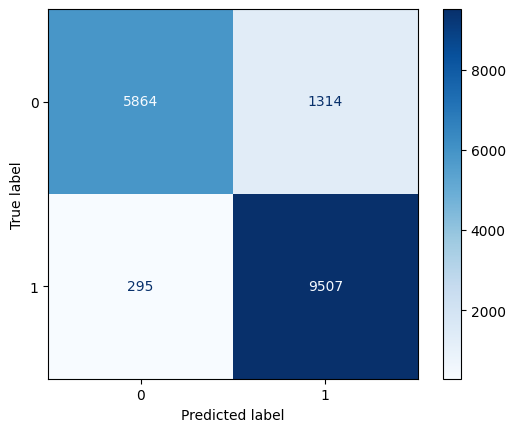

Mejores hiperparámetros: {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 10}
Exactitud: 0.91
Recall: 0.969904101203836
Precisión: 0.878569448294982
Puntuación F1: 0.9219803132424963


In [70]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 51),
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [10, 15, 20]
}

# Modelo base
arbol = DecisionTreeClassifier(criterion="gini", random_state=1)

# Aplicamos GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(arbol, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Entrenamos el modelo
grid_search.fit(X_train, Y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Métricas de evaluación
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Mejores hiperparámetros:", grid_search.best_params_)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred)))
print("Precisión: {}".format(precision_score(Y_test, y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test, y_pred)))
arbolExactitud=accuracy_score(Y_test, y_pred)
arbolRecall=recall_score(Y_test,y_pred)
arbolPrecision=precision_score(Y_test,y_pred)
arbolFScore=f1_score(Y_test,y_pred)

# Análisis del modelo de árbol de decisión

El siguiente mapa de confusión muestra el desempeño del modelo de árbol de decisión en la clasificación de noticias falsas.

## Interpretación del mapa de confusión

- **Verdaderos positivos (9507):** Noticias falsas correctamente identificadas como falsas.  
- **Verdaderos negativos (5864):** Noticias verdaderas correctamente identificadas como verdaderas.  
- **Falsos positivos (1314):** Noticias verdaderas clasificadas erróneamente como falsas.  
- **Falsos negativos (295):** Noticias falsas clasificadas erróneamente como verdaderas.  

## Métricas del modelo

- **Exactitud:** 0.91  
- **Recall:** 0.9699  
- **Precisión:** 0.8786  
- **Puntuación F1:** 0.9219  


El modelo tiene un desempeño sólido, especialmente en la detección de noticias falsas, con un recall alto que minimiza los falsos negativos. Sin embargo, la presencia de falsos positivos (1314) indica que algunas noticias legítimas son clasificadas erróneamente como falsas. 


## **3.2. K vecinos más cercanos - Mateo Barbosa**
K-Vecinos Cercanos (K-Nearest Neighbors, KNN) es un algoritmo de aprendizaje supervisado que clasifica un nuevo punto basándose en la mayoría de sus vecinos más cercanos. La clasificación se realiza midiendo la distancia entre el punto a clasificar y los datos de entrenamiento, asignándole la categoría más frecuente entre los K vecinos más cercanos. Este enfoque hace que el modelo sea intuitivo y fácil de interpretar, pero su desempeño depende en gran medida de la elección del número de vecinos y la métrica de distancia utilizada.

En este caso, se realizó una búsqueda de hiperparámetros con GridSearchCV para encontrar la mejor combinación de valores para el modelo. Los parámetros óptimos encontrados fueron `n_neighbors = 60` y `algorithm = 'brute'`, lo que sugiere que una mayor cantidad de vecinos ayuda a suavizar la clasificación, reduciendo el sobreajuste. Sin embargo, un valor demasiado alto podría afectar la capacidad del modelo para capturar detalles importantes en los datos.


C:\Users\soyyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.71974154]
  warnings.warn(


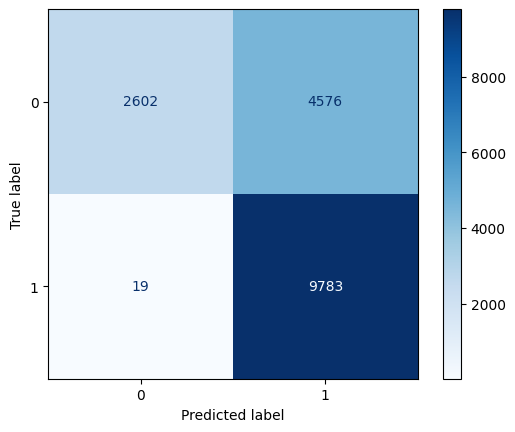

Mejores hiperparámetros: {'algorithm': 'brute', 'n_neighbors': 60}


In [73]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier()


param_grid = {
    'n_neighbors': [5, 15, 30, 45, 60],  
    'algorithm': ['auto', 'ball_tree', 'brute'] 
}


grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_modelKvecinos = grid_search.best_estimator_

y_pred = best_modelKvecinos.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_modelKvecinos.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print("Mejores hiperparámetros:", grid_search.best_params_)



In [75]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))
KVecinosExactitud=accuracy_score(Y_test, y_pred)
KVecinosRecall=recall_score(Y_test,y_pred)
KVecinosPrecision=precision_score(Y_test,y_pred)
KVecinosFScore=f1_score(Y_test,y_pred)

Exactitud: 0.73
Recall: 0.9980616200775352
Precisión: 0.6813148547949022
Puntuación F1: 0.809817474442283


# Análisis del Modelo de K-Vecinos  

El siguiente mapa de confusión muestra el desempeño del modelo de **K-Vecinos** en la clasificación de noticias falsas.  

## Interpretación del Mapa de Confusión  
- **Verdaderos positivos (9783)**: Noticias falsas correctamente identificadas como falsas.  
- **Verdaderos negativos (2602)**: Noticias verdaderas correctamente identificadas como verdaderas.  
- **Falsos positivos (4576)**: Noticias verdaderas clasificadas erróneamente como falsas.  
- **Falsos negativos (19)**: Noticias falsas clasificadas erróneamente como verdaderas.  

## Métricas del Modelo  
- **Exactitud**: 0.73  
- **Recall**: 0.9981  
- **Precisión**: 0.6813  
- **Puntuación F1**: 0.8098  

El modelo tiene un **recall muy alto**, lo que significa que casi todas las noticias falsas se identifican correctamente. Sin embargo, la **baja precisión** indica que muchas noticias verdaderas son clasificadas erróneamente como falsas (**4576 falsos positivos**). Esto puede ser problemático si se requiere un alto grado de confianza en la clasificación de noticias legítimas.

## **3.3. Gradient Boosting - Nicolas Lara**
Gradient Boosting es un algoritmo de aprendizaje supervisado basado en árboles de decisión secuenciales. Funciona construyendo múltiples árboles en serie, donde cada árbol intenta corregir los errores del anterior, optimizando la función de pérdida. Este enfoque permite mejorar la precisión del modelo a través de un aprendizaje iterativo, ajustando los pesos de las instancias mal clasificadas. Sin embargo, el número de árboles (`n_estimators`), la tasa de aprendizaje (`learning_rate`) y la profundidad máxima (`max_depth`) son parámetros clave que influyen en su desempeño y riesgo de sobreajuste.

En este caso, se utilizó GridSearchCV para encontrar los mejores hiperparámetros del modelo. La búsqueda abarcó diferentes combinaciones de estimadores, tasas de aprendizaje y profundidades de los árboles. Los mejores hiperparámetros encontrados fueron `learning_rate`: 0.1, `max_depth`: 5 y `n_estimators`: 150, lo que permitió mejorar la capacidad predictiva del modelo, logrando un equilibrio entre generalización y precisión. Finalmente, se evaluó el rendimiento mediante métricas como exactitud, recall, precisión y F1-score, además de visualizar la matriz de confusión para analizar su desempeño en la clasificación.

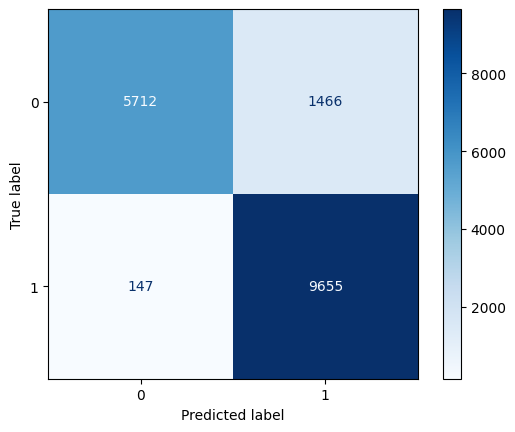

Exactitud: 0.91
Recall: 0.9850030605998775
Precisión: 0.8681773221832569
Puntuación F1: 0.9229078048081059
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [79]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 150], 
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4, 5] 
}

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_modelBoosting = grid_search.best_estimator_

y_pred = best_modelBoosting.predict(X_test)


cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_modelBoosting.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

print("Mejores hiperparámetros:", grid_search.best_params_)


In [80]:
GradientExactitud=accuracy_score(Y_test, y_pred)
GradientRecall=recall_score(Y_test,y_pred)
GradientPrecision=precision_score(Y_test,y_pred)
GradientFScore=f1_score(Y_test,y_pred)

# Análisis del Modelo de Gradient Boosting  

El siguiente mapa de confusión muestra el desempeño del modelo de **Gradient Boosting** en la clasificación de noticias falsas.  

## Interpretación del Mapa de Confusión  
- **Verdaderos positivos (9655)**: Noticias falsas correctamente identificadas como falsas.  
- **Verdaderos negativos (5712)**: Noticias verdaderas correctamente identificadas como verdaderas.  
- **Falsos positivos (1466)**: Noticias verdaderas clasificadas erróneamente como falsas.  
- **Falsos negativos (147)**: Noticias falsas clasificadas erróneamente como verdaderas.  

## Métricas del Modelo  
- **Exactitud**: 0.91  
- **Recall**: 0.9850  
- **Precisión**: 0.8682  
- **Puntuación F1**: 0.9229  

El modelo tiene un **buen balance entre precisión y recall**, logrando identificar correctamente la mayoría de las noticias falsas mientras mantiene un **bajo número de falsos negativos**. Sin embargo, **los 1466 falsos positivos** podrían afectar la confianza en la clasificación de noticias legítimas.  


# **Sección 4. Resultados**

## **4.1. Descripción de resultados obtenidos**

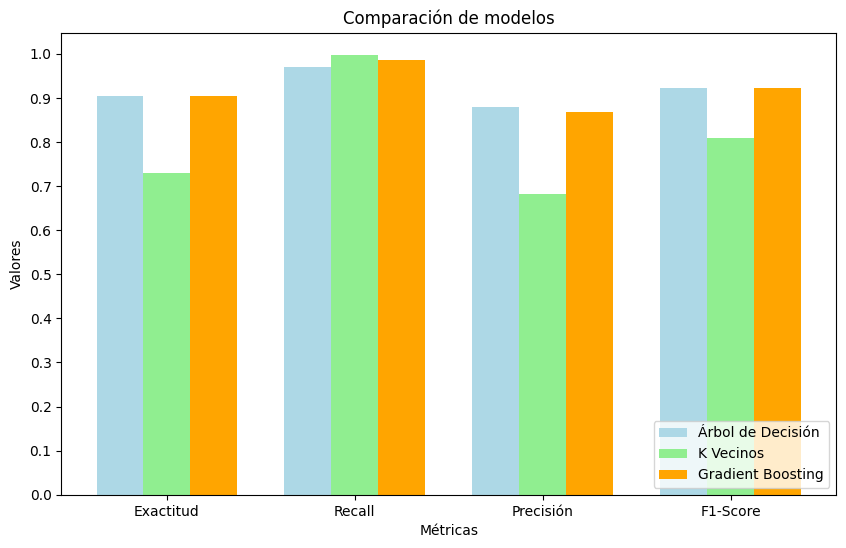

In [88]:
import numpy as np
metricas = ["Exactitud", "Recall", "Precisión", "F1-Score"]
arbol = [arbolExactitud, arbolRecall, arbolPrecision, arbolFScore]
kvecinos = [KVecinosExactitud, KVecinosRecall, KVecinosPrecision, KVecinosFScore]
gradient = [GradientExactitud, GradientRecall, GradientPrecision, GradientFScore]
x = np.arange(len(metricas))  
width = 0.25  
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, arbol, width, label="Árbol de Decisión", color='lightblue')
ax.bar(x, kvecinos, width, label="K Vecinos", color='lightgreen')
ax.bar(x + width, gradient, width, label="Gradient Boosting", color='orange')
ax.set_xlabel("Métricas")
ax.set_ylabel("Valores")
ax.set_title("Comparación de modelos")
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.legend(loc="lower right")
plt.show()

El proceso de detección de noticias falsas se evaluó utilizando tres modelos de machine learning: **Árbol de Decisión, K-Nearest Neighbors (KNN) y Gradient Boosting Classifier**. Cada modelo fue analizado en términos de exactitud, recall, precisión y F1-score, permitiendo determinar su desempeño y contribución a los objetivos del negocio.

### Árbol de Decisión
- **Exactitud:** 91%
- **Recall:** 96.99%
- **Precisión:** 87.86%
- **F1-score:** 92.20%

Este modelo muestra un equilibrio sólido entre recall y precisión, lo que indica que identifica correctamente la mayoría de las noticias falsas sin generar demasiados falsos positivos. Su alta F1-score sugiere que el modelo es confiable y efectivo para la clasificación de noticias falsas.

### K-Nearest Neighbors (KNN)
- **Exactitud:** 73%
- **Recall:** 99.81%
- **Precisión:** 68.13%
- **F1-score:** 80.98%

Si bien el recall es extremadamente alto, lo que indica que el modelo detecta casi todas las noticias falsas, su baja precisión sugiere una alta tasa de falsos positivos. Esto podría afectar la confiabilidad del sistema, ya que podría etiquetar erróneamente noticias reales como falsas, disminuyendo la confianza del usuario en la plataforma.

### Gradient Boosting Classifier
- **Exactitud:** 91%
- **Recall:** 98.50%
- **Precisión:** 86.82%
- **F1-score:** 92.29%

Este modelo tiene un recall alto, similar al árbol de decisión, pero con una precisión ligeramente menor. Su F1-score es el más alto de los tres modelos, lo que indica un buen balance entre la identificación correcta y la minimización de errores.

### Contribución a los Objetivos del Negocio
El objetivo del negocio es minimizar la propagación de noticias falsas sin afectar la credibilidad de las noticias reales. En este contexto, los modelos de **Árbol de Decisión** y **Gradient Boosting Classifier** ofrecen el mejor rendimiento, con valores de F1-score casi idénticos. Sin embargo, **Gradient Boosting Classifier** logra un recall superior sin comprometer significativamente la precisión, lo que lo convierte en la mejor opción si el objetivo principal es capturar la mayor cantidad de noticias falsas con la menor cantidad de errores posibles. En contraste, **KNN** tiene un recall alto pero una precisión baja, lo que podría generar una cantidad inaceptable de falsos positivos, afectando la confianza del usuario en la plataforma.


## **4.2. Análisis de palabras seleccionadas**


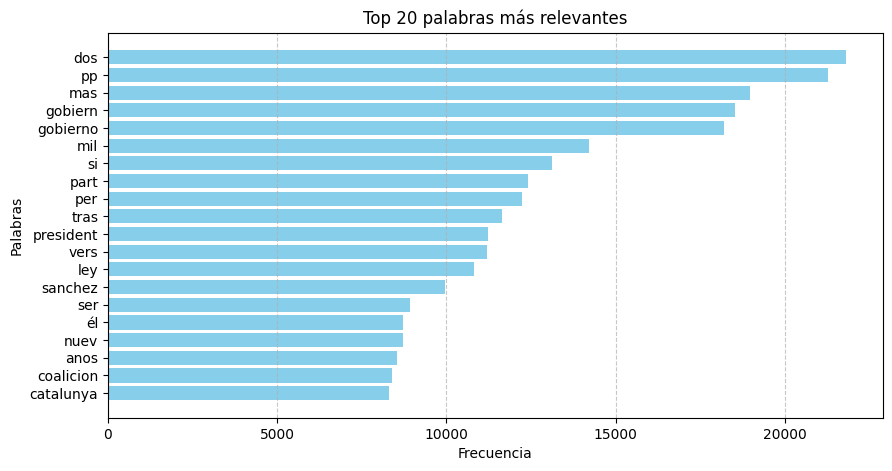

In [92]:
word_freq = np.asarray(X_count.sum(axis=0)).flatten()  # Frecuencia total de cada palabra
words = count.get_feature_names_out()  # Palabras seleccionadas

# Ordenar las palabras por frecuencia
sorted_indices = np.argsort(word_freq)[::-1]  # Índices ordenados de mayor a menor
top_words = words[sorted_indices[:20]]  # Seleccionar las 10 palabras más relevantes
top_freqs = word_freq[sorted_indices[:20]]  # Frecuencia de las 10 palabras más relevantes

# Graficar
plt.figure(figsize=(10, 5))
plt.barh(top_words[::-1], top_freqs[::-1], color='skyblue')  # Invertir para mejor visualización
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.title("Top 20 palabras más relevantes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Análisis de Palabras para la Detección de Noticias Falsas

## Análisis de las Palabras Seleccionadas  

Las palabras más frecuentes en las noticias analizadas incluyen términos políticos como **"gobierno"**, **"president"**, **"sanchez"**, **"coalición"**, **"catalunya"** y **"ley"**. Esto sugiere que gran parte del contenido se enfoca en temas de actualidad política.  

Para identificar noticias falsas, se pueden considerar los siguientes aspectos:  

1. **Palabras con connotación sesgada**  
   - Términos como **"pp"**, **"sanchez"** y **"gobierno"** pueden usarse en contextos que refuercen narrativas extremas.  

2. **Frecuencia de ciertos términos**  
   - La repetición excesiva de palabras como **"dos"**, **"mas"** y **"mil"** puede indicar estrategias de exageración en desinformación.  

3. **Uso de términos ambiguos o sensacionalistas**  
   - Palabras como **"tras"**, **"vers"** (posiblemente de "versión") y **"nuev"** (posiblemente de "nueva") pueden estar asociadas con titulares diseñados para atraer atención sin proporcionar información verificable.  


## Justificación de la Utilidad para la Organización  

### Automatización de la detección de fake news  
   - Identificar patrones de palabras recurrentes en noticias falsas puede ayudar a construir modelos de clasificación de texto para detección automática.  

### Mejor toma de decisiones  
   - Comprender qué términos están más relacionados con la desinformación permite desarrollar estrategias de fact-checking más efectivas.  

### Prevención de la propagación de fake news  
   - Si se detectan palabras clave asociadas a noticias falsas, se pueden generar alertas o priorizar la verificación en artículos que contengan esos términos.  

### Mejora en la educación mediática  
   - La información extraída puede servir para capacitar a usuarios finales sobre qué términos pueden estar relacionados con noticias engañosas.  

## Conclusión  

El análisis de términos relevantes permite mejorar la detección y prevención de fake news, optimizando la calidad de la información consumida por la organización y su audiencia.

## **4.3 Generar el modelo a partir de los datos**
Generar etiquetado con los datos de prueba y generar el csv. Con el modelo seleccionado que fue el árbol de decisión se generara el etiquetado de los datos de prueba y se exportará a un csv llamado fake_news_test_tag.csv que incluira la columna label que fue generada por el modelo

In [93]:
dataTestLoad=pd.read_csv("fake_news_test.csv", sep=";")
dataTest=dataTestLoad.copy()
dataTest['Titulo'] = dataTest['Titulo'].fillna("").apply(contractions.fix)
dataTest['Descripcion'] = dataTest['Descripcion'].fillna("").apply(contractions.fix)
dataTest['Descripcion_palabras'] = dataTest['Descripcion'].apply(word_tokenize)
dataTest['Titulo_palabras'] = dataTest['Titulo'].apply(word_tokenize)
dataTest['Descripcion_palabras'] = dataTest['Descripcion_palabras'].apply(preprocessing)
dataTest['Titulo_palabras'] = dataTest['Titulo_palabras'].apply(preprocessing)
dataTest["Descripcion_palabras"] = dataTest["Descripcion_palabras"].apply(stem_and_lemmatize)
dataTest["Titulo_palabras"] = dataTest["Titulo_palabras"].apply(stem_and_lemmatize)
dataTest['Descripcion_palabras'] = dataTest['Descripcion_palabras'].apply(lambda x: ' '.join(map(str, x)))
dataTest['Titulo_palabras'] = dataTest['Titulo_palabras'].apply(lambda x: ' '.join(map(str, x)))
dataTest["texto_combinado"]=dataTest["Titulo_palabras"]+" "+dataTest["Descripcion_palabras"]
Xtest= dataTest["texto_combinado"]
X_countTest = count.transform(Xtest)
Y_predTest=best_modelBoosting.predict(X_countTest)

In [96]:
dataTest["label"] = Y_predTest  # Agregar la columna de predicciones
dataTest.to_csv("fake_news_test_tag.csv", index=False)

# **Sección 5. Trabajo en equipo**

## 5.1. Distribución de Roles y Tareas

### Líder de Proyecto: Nicolás Lara
- **Tareas realizadas:** 
  - Gestionó la organización del equipo y las reuniones.
  - Definió fechas de entregas parciales y verificó el cumplimiento de las tareas.
  - Coordinó la carga de trabajo y la equidad en la distribución de tareas.
  - Subió la entrega final al repositorio asignado.
- **Tiempo dedicado:** 15 horas.
- **Retos enfrentados:** Coordinación de horarios del equipo y ajuste de fechas de entrega.
- **Solución propuesta:** Uso de herramientas como Google Calendar y Trello para organizar mejor las tareas.

### Líder de Datos: Joan Amaya
- **Tareas realizadas:** 
  - Gestionó la limpieza y procesamiento de los datos.
  - Se aseguró de que los datos estuvieran disponibles para todo el equipo en el repositorio de GitHub.
  - Aplicó transformaciones como tokenización, eliminación de stopwords y combinación de campos.
- **Tiempo dedicado:** 20 horas.
- **Retos enfrentados:** Manejo de datos con ruido y procesamiento de texto en español.
- **Solución propuesta:** Uso de librerías como NLTK y spaCy para mejorar la limpieza de datos.

### Líder de Analítica: Mateo Barbosa
- **Tareas realizadas:** 
  - Implementó y evaluó modelos de Machine Learning.
  - Comparó algoritmos como Árbol de Decisión, KNN y Gradient Boosting.
  - Optimizó hiperparámetros usando GridSearchCV.
- **Tiempo dedicado:** 25 horas.
- **Retos enfrentados:** Selección del mejor modelo y ajuste de hiperparámetros.
- **Solución propuesta:** Pruebas con diferentes combinaciones de features y evaluación de métricas como F1-score y recall.

## 5.2. Uso de ChatGPT en el Proyecto
- Búsqueda de explicaciones sobre algoritmos y métricas.
- Generación de ideas para el preprocesamiento de datos.
- Redacción de partes del informe y estructuración del reporte final.

## 5.3. Distribución de 100 Puntos entre los Integrantes
- **Nicolás Lara:** 34 puntos.
- **Joan Amaya:** 33 puntos.
- **Mateo Barbosa:** 33 puntos.

## 5.4. Puntos a Mejorar para la Siguiente Entrega
- Mejor distribución del tiempo para cada tarea.
- Mayor documentación del código para facilitar su comprensión.
- Automatización de algunos procesos de preprocesamiento de datos.
- Evaluación de nuevos métodos para mejorar la detección de noticias falsas.
